### The following the code follows the KDD Process for the Threat and Weakness Analysis 

# 1. Data Selection:

Identify and extract relevant data from log files while filtering out irrelevant information.

- **Data Origin:** Logs were sourced from monitoring tools and event management systems, specifically collected via the *Graylog server*.
- **Format:** *.log* format.
- **Size:** 3.34 GB
- **Features:**
  - Timestamps
  - PID
  - Logger
  - Message
  - Scope (e.g., TraceId, RequestID)
  - Application
  - State
  - EventID

# 2. Data Preparation:

 - Consolidated nine individual log files into a single file.
 - Converted the consolidated file from \textit{.log} format to \textit{CSV} format.

In [ ]:
import os
import json
import pandas as pd

# Folder path containing all .log files
folder_path = "/Users/vatsal/Desktop/SimplyTag"  # Replace with your folder path
output_csv_path = "/Users/vatsal/Desktop/SimplyTag/merged_logs.csv"

# Initialize a list to store JSON data from all files
log_data = []

# Process each .log file in the folder
for file_name in os.listdir(folder_path):
    if file_name.endswith(".log"):  # Check if the file is a .log file
        log_file_path = os.path.join(folder_path, file_name)
        print(f"Processing file: {log_file_path}")
        
        # Read the log file line by line
        with open(log_file_path, "r") as file:
            for line in file:
                # Find the JSON part of each line
                json_start = line.find('{')
                if json_start != -1:
                    json_data = line[json_start:].strip()
                    try:
                        # Parse the JSON and append it to the list
                        log_data.append(json.loads(json_data))
                    except json.JSONDecodeError:
                        print(f"Skipping invalid JSON in file {file_name}: {json_data}")

# Convert the combined list of JSON objects to a DataFrame
if log_data:
    df = pd.DataFrame(log_data)

    # Save the DataFrame to a single CSV file
    df.to_csv(output_csv_path, index=False)
    print(f"All log data successfully merged and saved to {output_csv_path}")
else:
    print("No valid log entries found in the provided files.")


# 3. Data Transformation:

- Grouped log entries by TraceId to rebuild complete request flows.
- Parsed fields from nested JSON structures: TraceId, HTTP Status Code, Path, User-Agent.

In [ ]:
# Load the CSV file
df = pd.read_csv("/Users/vatsal/Desktop/SimplyTag/merged_logs.csv", low_memory=False)

# Function to safely parse JSON
def parse_json_safe(json_str):
    try:
        # Replace single quotes with double quotes for valid JSON
        return json.loads(json_str.replace("'", '"'))
    except (json.JSONDecodeError, TypeError):
        return None

# Parse 'Scope' and 'State' columns
df['Scope'] = df['Scope'].apply(lambda x: parse_json_safe(x) if isinstance(x, str) else None)
df['State'] = df['State'].apply(lambda x: parse_json_safe(x) if isinstance(x, str) else None)

# Initialize a new DataFrame for selected data
df_selected = pd.DataFrame()

# Extract specific fields after parsing JSON
df_selected['Timestamp'] = df['Timestamp']

# Extract Trace-id from Scope regardless of its position
def extract_trace_id(scope):
    if isinstance(scope, dict):
        for key, value in scope.items():
            if key == 'TraceId':  # Match key case-sensitively
                return value
    return None

df_selected['Trace-id'] = df['Scope'].apply(extract_trace_id)

# Extract Path from State regardless of its position
def extract_trace_id(State):
    if isinstance(State, dict):
        for key, value in State.items():
            if key == 'Path':  # Match key case-sensitively
                return value
    return None

df_selected['Path'] = df['State'].apply(extract_trace_id)




# Extract other fields from State
df_selected['HTTP Status Code'] = df['State'].apply(lambda x: x.get('StatusCode') if isinstance(x, dict) else None)
#df_selected['Path'] = df['State'].apply(lambda x: x.get('Path') if isinstance(x, dict) else None)
df_selected['User Agent'] = df['State'].apply(lambda x: x.get('User-Agent') if isinstance(x, dict) else None)

# Inspect the extracted data
print("Extracted Data:\n", df_selected.head())

# Save the cleaned and selected data to a new CSV file
output_csv_path = "/Users/vatsal/Desktop/SimplyTag/transformed_data1.csv"
df_selected.to_csv(output_csv_path, index=False)
print(f"Selected data has been saved to {output_csv_path}")


- After doing the initial transformation, with the help of Excel we have manually excluded entries without a valid TraceId that contain generic error or warning messages and saved in the transformed_data file.

# 4. Data Mining and Modelling:

- Converting raw data into a structured format suitable for machine learning.

## Feature Extraction:

### Approach 1: Path-Based Features 

- Extracted key features based on the Path attribute. Features included:
    - Path length
    - Presence of special characters
    - SQL keywords
    - Path traversal attempts
    - Suspicious file extensions

In [ ]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import IsolationForest
from sklearn.cluster import DBSCAN
import re

# File path
file_path = '/Users/vatsal/Desktop/transformed_data.csv'  # Adjust as needed

# Function to extract features from the 'Path' column
def extract_path_features(path):
    features = {
        'path_length': len(str(path)),
        'special_chars': len(re.findall(r'[^a-zA-Z0-9/]', str(path))),
        'has_sql_keywords': 1 if re.search(r'(select|union|delete|drop|insert|exec|update)', str(path).lower()) else 0,
        'has_path_traversal': 1 if '..' in str(path) or '//' in str(path) else 0,
        'has_suspicious_extensions': 1 if re.search(r'\.(php|asp|aspx|exe|bat|cmd)$', str(path).lower()) else 0
    }
    return pd.Series(features)

# Initialize results storage for anomalies
chunk_results = []

# Read and process the dataset in chunks
chunk_size = 10000
chunks = pd.read_csv(file_path, chunksize=chunk_size)

for chunk in chunks:
    # Fill missing values
    chunk['HTTP Status Code'].fillna(-1, inplace=True)
    chunk['User Agent'].fillna('Unknown', inplace=True)

    # Extract path features
    path_features = chunk['Path'].apply(extract_path_features)
    
    # Add frequency of paths as a feature
    chunk['path_frequency'] = chunk['Path'].map(chunk['Path'].value_counts())
    
    # Combine features
    X = pd.concat([
        path_features,
        pd.get_dummies(chunk['HTTP Status Code'].astype(int), prefix='status'),
        chunk[['path_frequency']]
    ], axis=1)

    # Normalize features
    scaler = StandardScaler()
    X_scaled = scaler.fit_transform(X)

    # Anomaly Detection: Isolation Forest
    iso_forest = IsolationForest(contamination=0.05, random_state=42)
    chunk['is_anomaly_iso'] = iso_forest.fit_predict(X_scaled)

    # Anomaly Detection: DBSCAN
    dbscan = DBSCAN(eps=0.5, min_samples=5)
    chunk['is_anomaly_dbscan'] = dbscan.fit_predict(X_scaled)

    # Combine results from both models
    chunk['is_anomaly_combined'] = (chunk['is_anomaly_iso'] == -1) | (chunk['is_anomaly_dbscan'] == -1)

    # Store anomalies from this chunk
    chunk_anomalies = chunk[chunk['is_anomaly_combined']]
    chunk_results.append(chunk_anomalies)

# Combine anomalies from all chunks
anomalies = pd.concat(chunk_results, ignore_index=True)

# Save anomalies to a CSV file
output_file = "anomalies_detected_approach1.csv"
anomalies.to_csv(output_file, index=False)

# Display summary
print(f"Total number of rows processed: {chunk_size * len(chunk_results)}")
print(f"Total anomalies detected: {len(anomalies)}")
print("\nSample of detected anomalies:")
print(anomalies[['Path', 'HTTP Status Code', 'User Agent']].head())

# Analyze HTTP Status Code distribution in anomalies
print("\nHTTP Status Code distribution in anomalies:")
print(anomalies['HTTP Status Code'].value_counts())

### Approach 2: Path-Based Features 

- Applied TF-IDF vectorization on the Path attribute to convert API endpoint access into numerical features for machine learning.

In [ ]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.cluster import DBSCAN
from sklearn.ensemble import IsolationForest
import numpy as np
import pandas as pd



# Load the dataset
file_path = '/Users/vatsal/Desktop/transformed_data.csv'
data = pd.read_csv(file_path)

# Handle missing values in 'Path'
data['Path'] = data['Path'].fillna('')

# Align data to trace_features indices
data = data.reindex(trace_features.index)

# Define the vectorizer
vectorizer = TfidfVectorizer(max_features=500)

# TF-IDF Transformation
tfidf_matrix = vectorizer.fit_transform(data['Path']).toarray()

# Prepare numeric features
numeric_features = trace_features[feature_cols].values

# Check for alignment and dimensions
print(f"TF-IDF Matrix Shape: {tfidf_matrix.shape}")
print(f"Numeric Features Shape: {numeric_features.shape}")
assert numeric_features.shape[0] == tfidf_matrix.shape[0], "Row counts still do not match!"

# Combine features
combined_features = np.hstack([numeric_features, tfidf_matrix])

# Proceed with clustering
dbscan_model = DBSCAN(eps=0.5, min_samples=5)
trace_features['DBSCAN_Cluster'] = dbscan_model.fit_predict(combined_features)

In [ ]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.cluster import DBSCAN
from sklearn.ensemble import IsolationForest
import numpy as np

# TF-IDF on Paths
vectorizer = TfidfVectorizer(max_features=500)
tfidf_matrix = vectorizer.fit_transform(data['Path']).toarray()

# Combine TF-IDF features with numeric features
numeric_features = trace_features[feature_cols].values
combined_features = np.hstack([numeric_features, tfidf_matrix])

# DBSCAN for density-based clustering
dbscan_model = DBSCAN(eps=0.5, min_samples=5)
trace_features['DBSCAN_Cluster'] = dbscan_model.fit_predict(combined_features)

# Identify potential anomalies (cluster = -1 in DBSCAN)
anomalies_dbscan = trace_features[trace_features['DBSCAN_Cluster'] == -1]

print(f"Total Anomalies Found by DBSCAN: {len(anomalies_dbscan)}")
print(anomalies_dbscan.head())

# Isolation Forest with refined features
model = IsolationForest(n_estimators=100, contamination=0.01, random_state=42)
trace_features['Isolation_Anomaly'] = model.fit_predict(combined_features)

# Analyze the intersection of DBSCAN and Isolation Forest anomalies
combined_anomalies = trace_features[
    (trace_features['DBSCAN_Cluster'] == -1) | (trace_features['Isolation_Anomaly'] == -1)
]
print(f"Total Combined Anomalies: {len(combined_anomalies)}")
combined_anomalies.head()

# Save anomalies to a CSV file
output_file = "anomalies_detected_approach2.csv"
anomalies.to_csv(output_file, index=False)

### Approach 3: User-Agent Analysis

- Analyzed User-Agent strings to identify patterns associated with malicious or unusual behaviors.

In [ ]:
import pandas as pd

# Load the dataset
file_path = "/Users/vatsal/Desktop/transformaed_data.csv"  # Replace with your file path
data = pd.read_csv(file_path)

# List of suspicious User-Agents
suspicious_user_agents = [
    "Mozilla/5.0 (Macintosh; Intel Mac OS X 10_15_7) AppleWebKit/605.1.15 (KHTML, like Gecko) Version/17.8 Mobile/15E148 Safari/604.1",
    "Mozilla/5.0 (ZZ; Linux i686; rv:125.0) Gecko/20100101 Firefox/125.0",
    "Mozilla/5.0 (compatible; CensysInspect/1.1; +https://about.censys.io/)",
    "Mozilla/5.0 (compatible; InternetMeasurement/1.0; +https://internet-measurement.com/)",
    "Mozilla/4.0 (compatible; MSIE 6.0; Windows NT 5.1; SV1; .NET CLR 1.1.4322; .NET CLR 2.0.50728)",
    "Mozilla/5.0 (ZZ; Linux x86_64) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/124.0.0.0 Safari/537.36",
    "Expanse, a Palo Alto Networks company, searches across the global IPv4 space multiple times per day to identify customers&#39; presences on the Internet. If you would like to be excluded from our scans, please send IP addresses/domains to: scaninfo@paloaltonetworks.com"
]

# Filter the dataset to find matching entries
filtered_data = data[data['User Agent'].isin(suspicious_user_agents)]

# Select relevant columns: TraceId, Path, User Agent, and HTTP Status Code
filtered_data = filtered_data[['Path', 'User Agent', 'HTTP Status Code']]

# Display the filtered data
print("Suspicious User-Agent Entries:")
print(filtered_data)

# Save the filtered data to a CSV file
output_file = "anomalies_useragents_approach3.csv"
filtered_data.to_csv(output_file, index=False)
print(f"\nFiltered data saved to {output_file}")

# 6. Validation/Verification:

## DBSCAN Validation
- **Cluster Review:** Verified data points within clusters had similar patterns.
- **Anomaly Inspection:** Manually checked anomalies (Cluster = -1) for normal deviations.


## Isolation Forest Validation
- **Anomaly Score Distribution:** Assessed scores to differentiate anomalies from regular requests.
- **Manual Inspection:** Reviewed flagged anomalies to confirm their unusual characteristics.

# 7. Data Visualisation: 

- **Figure 1**: Visualizing anomalies identified via `Path` and `TraceId`, showing clustering and deviations from normal access patterns.
- **Figure 2**: Analysis of anomalies detected based on `User-Agent` behaviors.


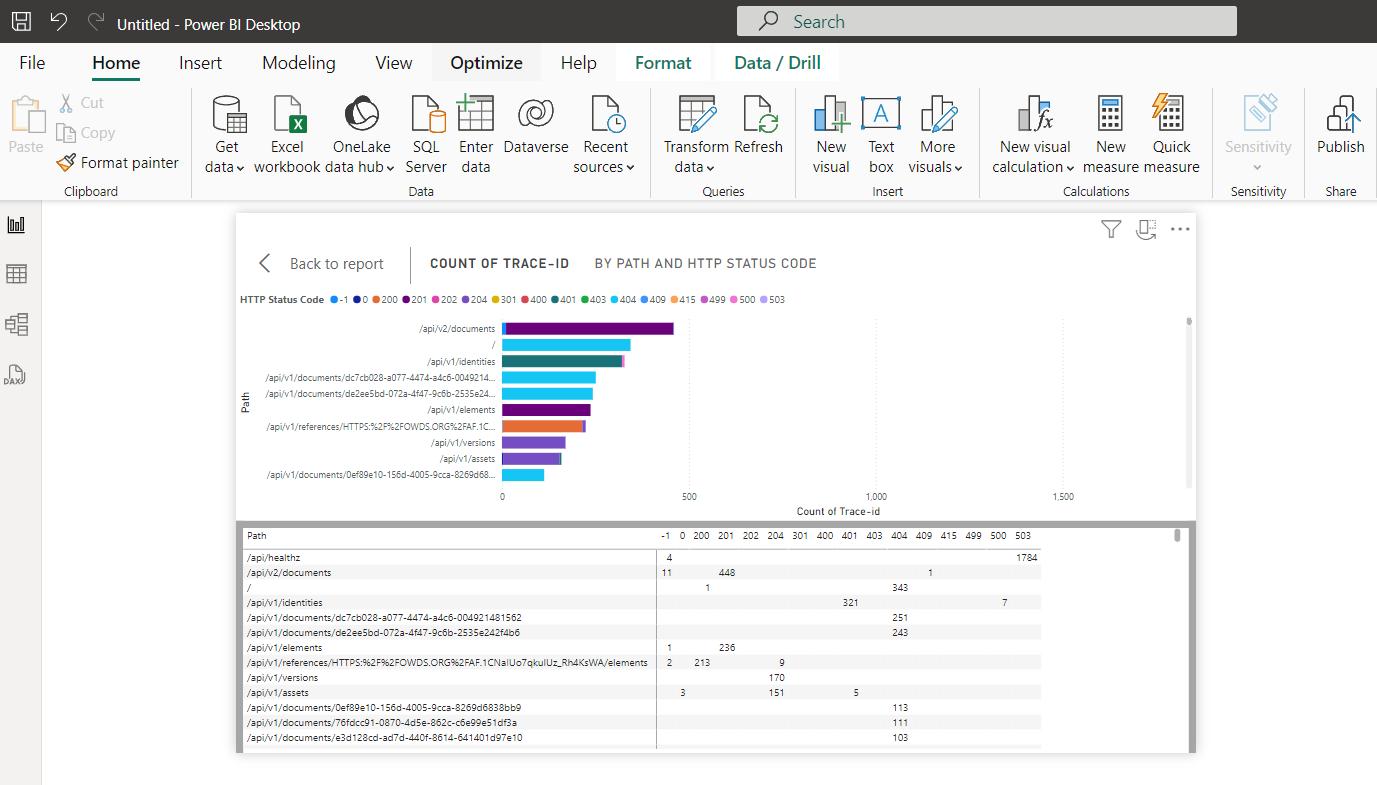

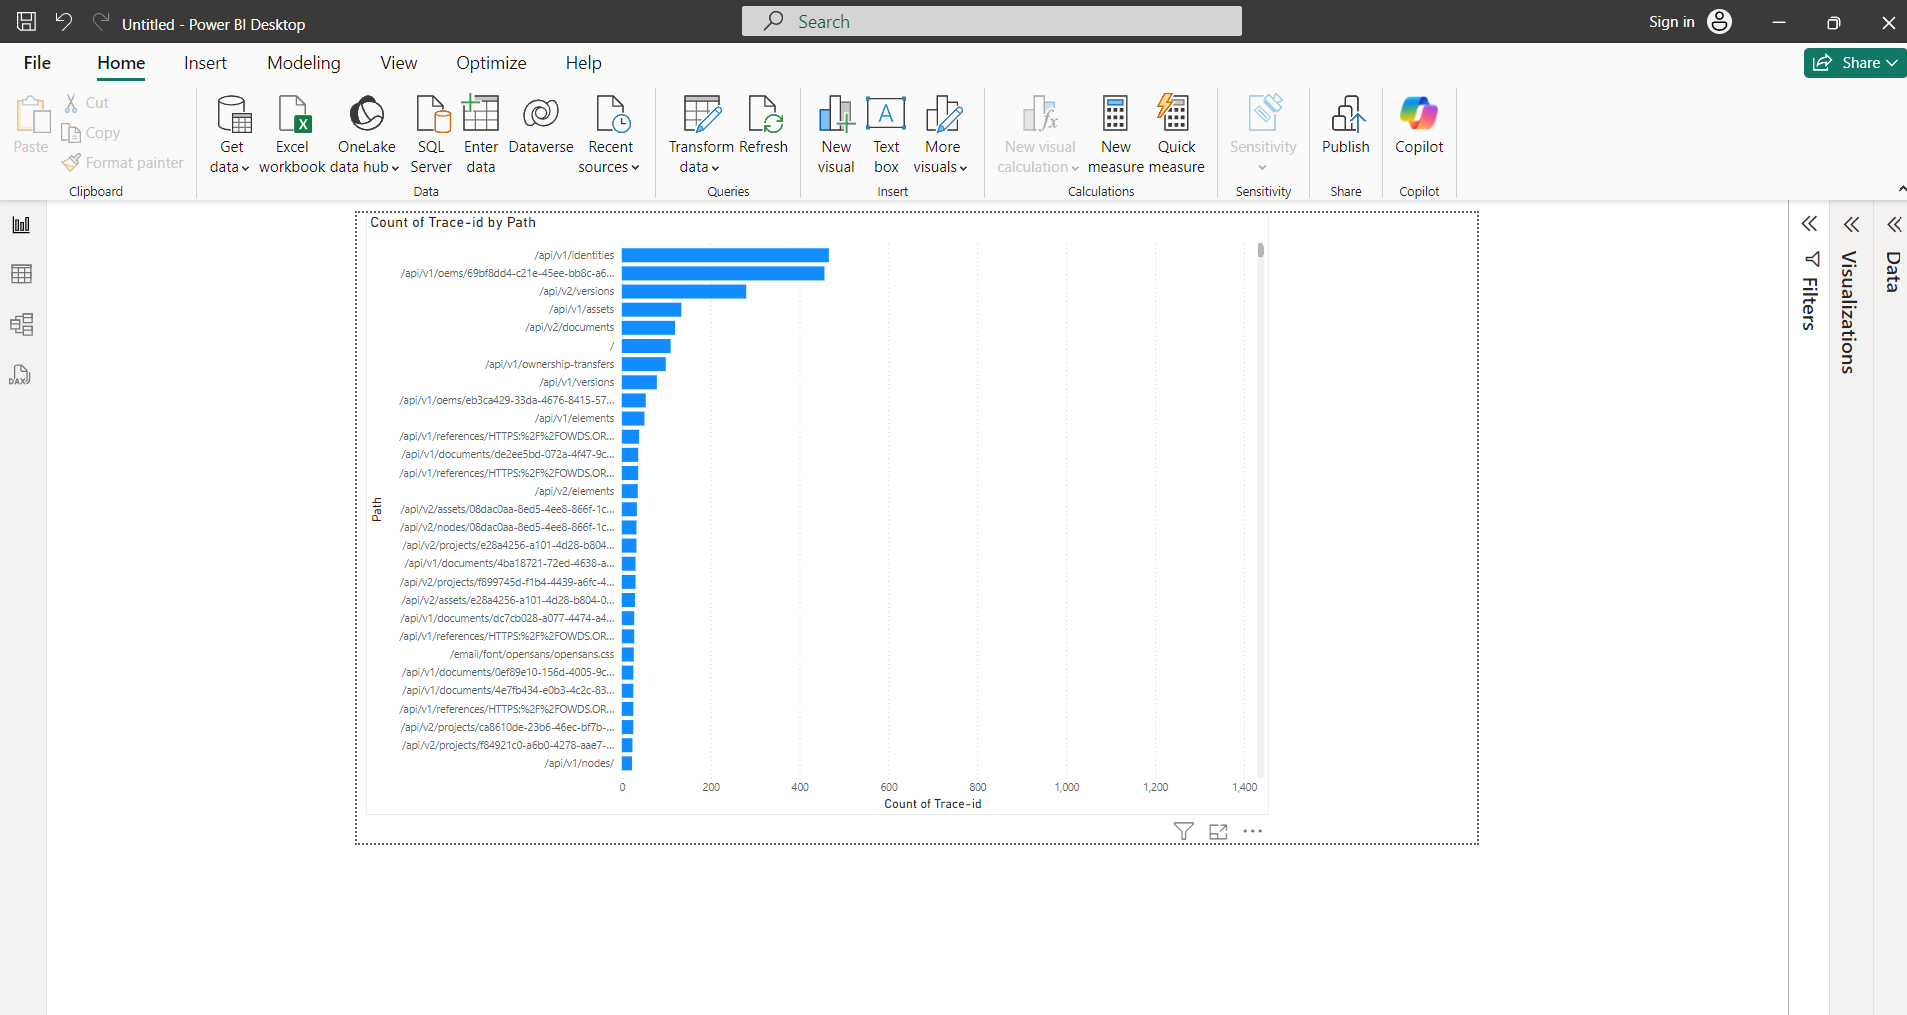

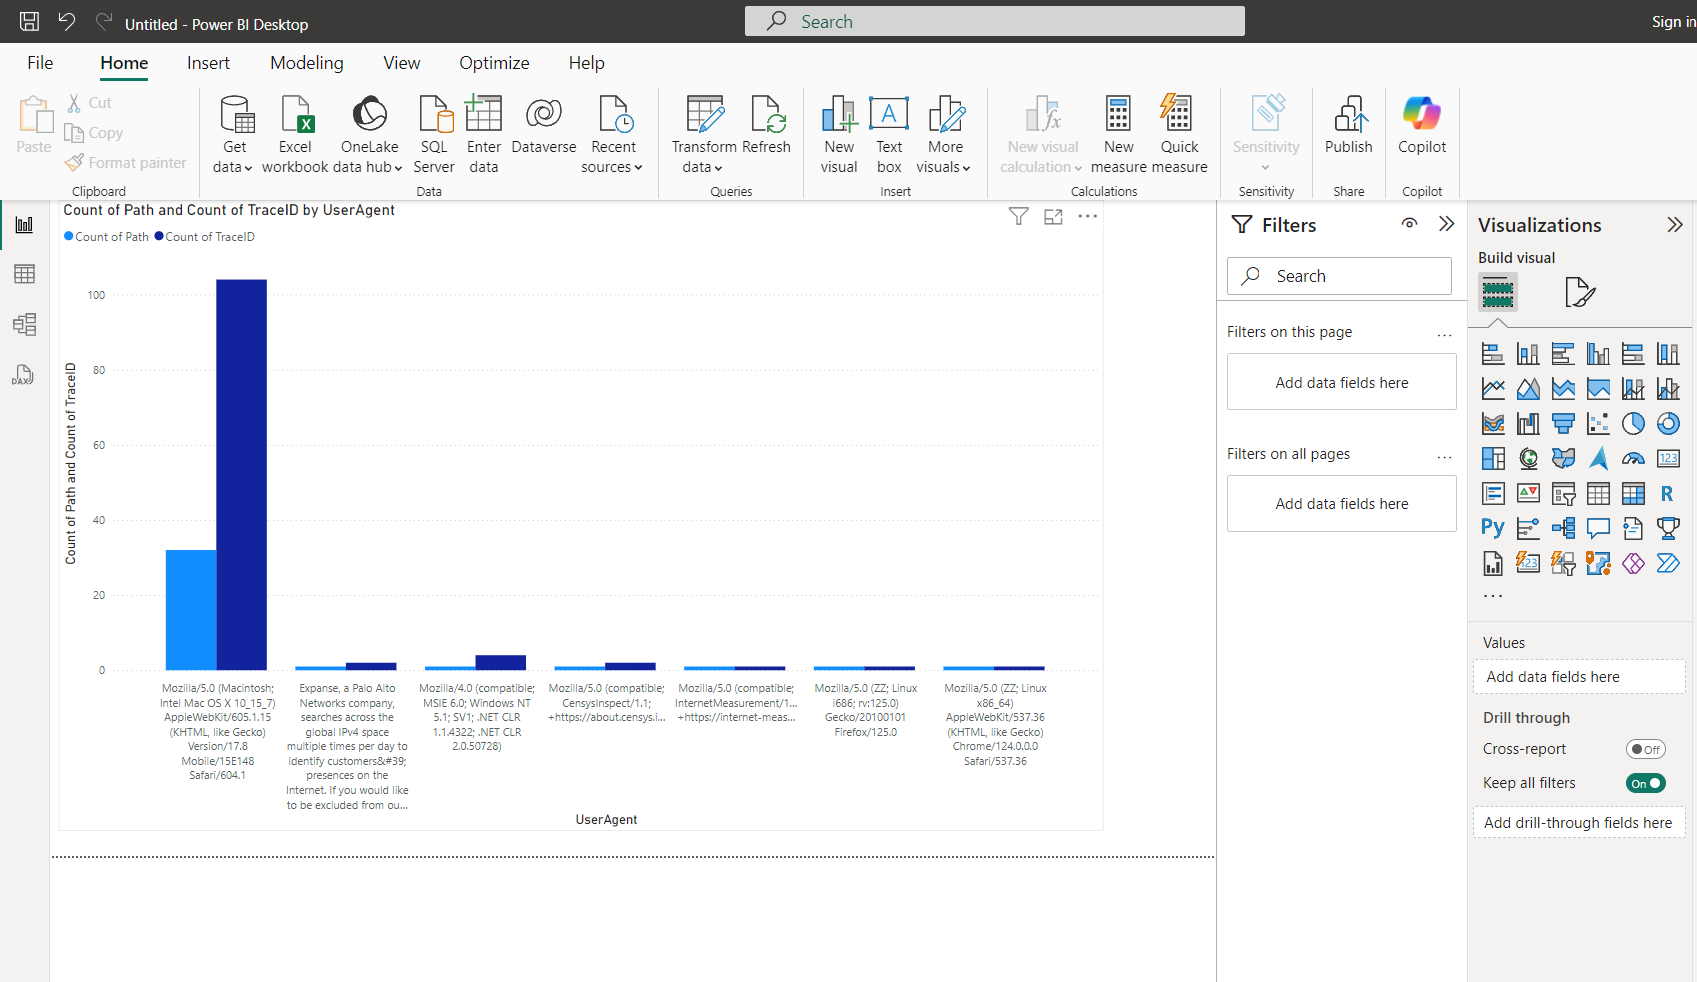

In [5]:
from IPython.display import Image, display

images = ["/Users/vatsal/Documents/GitHub/Data_Science_Project_2024/code/PowerBI1.png", "/Users/vatsal/Documents/GitHub/Data_Science_Project_2024/code/PowerBI2.png", "/Users/vatsal/Documents/GitHub/Data_Science_Project_2024/code/PowerBI3.png"]
for img in images:
    display(Image(filename=img))